In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
from scipy.special import erf
import sys
import warnings
warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'

mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

In [3]:
from functions_beh import*
from odor_breathing_functions import*

In [56]:
def get_sniff_histogram_1(session,shuffled=False):
    bins = np.linspace(0,250,16) #16
    num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15)) #15
        
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        if len(sniff_raw) == 11500:
            sniff_raw = sniff_raw[2500:]
            
        #print(len(sniff_raw))
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_phase = np.zeros((10000,))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]

        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

In [101]:
def get_sniff_histogram_beta(session,shuffled=False):
    bins = np.linspace(0,250,16) #16
    num_trials = session['num_trials']
    s_epoch = session['delay_time']*1000
    trial_pre_breath_period = len(session['trial_pre_breath'][0])
    trial_breath_period = len(session['trial_breath'][0])
    go_period = trial_breath_period - s_epoch
    sampling_beg = trial_pre_breath_period-250
    sampling_end = int(trial_pre_breath_period+s_epoch+250)
    sniff_hist = np.zeros((num_trials,15)) #15
        
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>sampling_beg]
        sniff_onset = sniff_onset[sniff_onset<sampling_end]
        sniff_phase = np.zeros((len(sniff_raw),))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        
        sniff_phase_sampling_epoch = sniff_phase[int(trial_pre_breath_period):]
        odor_command = session['trial_odor'][i_trial]

        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,s_epoch,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:int(s_epoch)]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

In [105]:
path = os.getcwd() + '/Session/'
#fname = 'Bengal_20190430_0.pickle'
fname = 'Tabby_20190423_0.pickle'

all_high_trials = np.zeros((0,))
all_cum_odor = np.zeros((0,))

session_fname = path + 'session_' + fname

with open(session_fname,'rb') as handle:
    session_list = pickle.load(handle)

    session = session_list[0]
    
    print(session.keys())

    num_trials = session['num_trials']
                            
    #autocorr_list.append(get_autocorr(session,num_hist))
    #session['conv_trial_odor'],session['conv_weights'] = get_conv_odor(session)
    #session['sniff_durations'] = get_sniff_durations(session)
    non_idle_trials = np.invert(session['idle_trials'])
    print(len(non_idle_trials), non_idle_trials.sum())
    # early_trials = session['early_trials']
    # print(len(early_trials), early_trials.sum())

    correct_trials = session['correct_trials'][non_idle_trials]
    #print(len(correct_trials))

    high_trials = session['high_trials'][non_idle_trials]
    low_trials = session['low_trials'][non_idle_trials]
    high_choices = (correct_trials==high_trials)
    trial_odor = session['trial_odor'][non_idle_trials]
    #sniff_durations = session['sniff_durations'][non_idle_trials]
    #sniff_durations = sniff_durations[sniff_durations>0] 
    #odor_profile_trial = ç(trial_odor)
    #pasting all the sniff durations of the session in just one array
    #sniff_hist = get_sniff_histogram(session,False)[non_idle_trials]
    # odor_onset = find_odor_onsets_new(trial_odor)#.astype(np.float)
    #coef_var  = get_blanks_duration(odor_onset)[1]
    #sniff_hist_shuffled = get_sniff_histogram(session,True)[non_idle_trials]
    cum_odor = np.ceil(trial_odor.sum(axis=1)/5000)
    #num_trials_taken = len(high_trials) - num_hist
    #previous_ind = np.arange(num_trials_taken).reshape(-1,1)+np.arange(0,num_hist)
    #previous_trials = high_choices[previous_ind]

all_cum_odor = np.append(all_cum_odor,cum_odor)

#print(high_trials[:6])

high_seven = all_cum_odor>8
low_eight = all_cum_odor<=8
all_high_trials = np.append(all_high_trials, high_trials)
all_low_trials = np.invert(all_high_trials.astype(np.bool))
bad_trials_1 = np.logical_and(high_seven,all_low_trials)
bad_trials_2 = np.logical_and(low_eight,all_high_trials)
bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
good_trials = np.invert(bad_trials)
print(good_trials.sum())
print(np.argwhere(bad_trials==True))
print(session['delay_time'])
print(len(session['trial_pre_breath'][0]))
print(session['trial_breath'].shape)


#print(all_high_trials[31])

dict_keys(['animal', 'year', 'month', 'day', 'session_id', 'type', 'num_trials', 'go_time', 'delay_time', 'refract_time', 'high_count', 'low_count', 'lick_training', 'free_drop', 'pulse_time_ms', 'performance', 'correct_trials', 'failure_trials', 'idle_trials', 'high_trials', 'low_trials', 'high_choice', 'low_choice', 'trial_odor', 'trial_breath', 'trial_pre_breath'])
205 171
169
[[ 34]
 [121]]
5.0
2500
(205, 7500)


In [110]:
print(session['session_id'])
print(session['high_count'])#.keys())
print(session['low_count'])#.keys())

0
12.5
4.166666666666667


In [102]:
#sh_1 = get_sniff_histogram_1(session, False)[non_idle_trials]
sh_beta = get_sniff_histogram_beta(session, True)[non_idle_trials]
#diff = sh_1 - sh_beta
#print(diff.sum(1))
sh_beta

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 2., 2.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [2., 2., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

ValueError: operands could not be broadcast together with shapes (228,15) (228,) 

11500
[  201   519   837  1130  1440  1777  2123  2411  2736  3041  3336  3638
  3959  4379  4715  5054  5377  5729  6047  6378  6679  6955  7391  7715
  8063  8359  8687  9022  9350  9578  9682  9998 10272 10402 10744 11030
 11304]


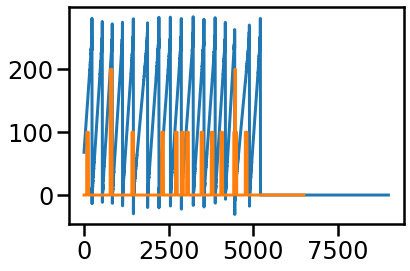

In [42]:

trial = 10
test_sniff_raw = np.append(session['trial_pre_breath'][trial],session['trial_breath'][trial])
print(len(test_sniff_raw))
sniff = butter_lowpass_filter(test_sniff_raw,8,1000,3)
sniff = (sniff - sniff.mean() +1)/2
sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
print(sniff_onset)
sniff_onset = sniff_onset[sniff_onset>2250]
sniff_onset = sniff_onset[sniff_onset<7750]
sniff_phase = np.zeros((10000,))

for i in range(len(sniff_onset)-1):
    nsample = sniff_onset[i+1]-sniff_onset[i]
    sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)



sniff_phase_sampling_epoch = sniff_phase[2500:]
plt.plot(sniff_phase_sampling_epoch)
odor_command = session['trial_odor'][trial]
plt.plot(odor_command)

# if shuffled:
#     n_pulses = (np.diff(odor_command)==100).sum()
#     valve_onset = np.random.randint(0,5000,(n_pulses,))
# else:
valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
odor_onset = valve_onset + 20

5000.0 5000 6500 1500.0
[  236   495   783  1073  1381  1678  1991  2228  2344  2682  3019  3309
  3610  3932  4295  4631  4933  5298  5569  5874  6206  6568  6895  7214
  7532  7861  8187  8505  8827  9182  9527  9852 10150 10390 10538 10820
 11077 11349]
4750 10250
[ 4933  5298  5569  5874  6206  6568  6895  7214  7532  7861  8187  8505
  8827  9182  9527  9852 10150]


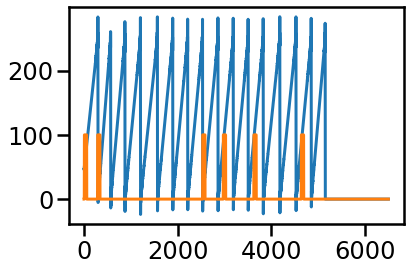

In [55]:
trial = 5
s_epoch = session['delay_time']*1000
trial_pre_breath_period = len(session['trial_pre_breath'][0])
trial_breath_period = len(session['trial_breath'][0])
go_period = trial_breath_period - s_epoch
print(s_epoch, trial_pre_breath_period, trial_breath_period, go_period)

test_sniff_raw = np.append(session['trial_pre_breath'][2],session['trial_breath'][2])
sniff = butter_lowpass_filter(test_sniff_raw,8,1000,3)
sniff = (sniff - sniff.mean() +1)/2
sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
print(sniff_onset)
sampling_beg = trial_pre_breath_period-250
sampling_end = int(trial_pre_breath_period+s_epoch+250)

print(sampling_beg, sampling_end)
sniff_onset = sniff_onset[sniff_onset>sampling_beg]
sniff_onset = sniff_onset[sniff_onset<sampling_end]
print(sniff_onset)
sniff_phase = np.zeros(len(test_sniff_raw),)

for i in range(len(sniff_onset)-1):
    nsample = sniff_onset[i+1]-sniff_onset[i]
    sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)

sniff_phase_sampling_epoch = sniff_phase[int(trial_pre_breath_period):] #2500 len(session['trial_pre_breath'])
plt.plot(sniff_phase_sampling_epoch)
odor_command = session['trial_odor'][trial]
plt.plot(odor_command)

# if shuffled:
#     n_pulses = (np.diff(odor_command)==100).sum()
#     valve_onset = np.random.randint(0,5000,(n_pulses,))
# else:
valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
odor_onset = valve_onset + 20


In [6]:
print(cum_odor[good_trials][0:10])
print(sniff_hist[good_trials][0:10,:])

[ 3.  6. 12. 16. 12. 10.  2.  5.  3.  3.]
[[0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 2. 0. 0. 2. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0. 2. 2. 2. 0. 2. 3. 3. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 2. 0. 1. 2. 0. 5. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 3. 1. 1. 3. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]]


In [87]:
print(all_high_trials[bad_trials])
print(correct_trials[bad_trials])

[0. 0. 0.]
[ True False False]


In [5]:
print(session['high_count'])
print(session['low_count'])


12.5
4.166666666666667


In [4]:
def find_odor_onset_new(trial_odor):
    odor_onsets_list = list()

    for i_trial in range(len(trial_odor)):
        onset_marks = (np.diff(trial_odor[i_trial])>0).astype(np.float)
        pulse_onsets = np.argwhere(onset_marks==1).flatten()
        #print(pulse_onsets)
        odor_onsets_list.append(pulse_onsets.tolist())
    return odor_onsets_list


In [8]:
print(trial_odor.shape)
new_onsets = find_odor_onset_new(trial_odor)
#print(new_onsets[0])
#print((test_onsets[0:20]))
print(new_onsets[0])
print(session['low_count'])

(53, 6500)
[351, 912, 1274, 1290, 2170, 2201, 2301, 2445, 2668, 3366, 3413, 3446, 3927, 3978, 4150, 4565, 4656, 4799]
5.128205128205129


6.0
False True False


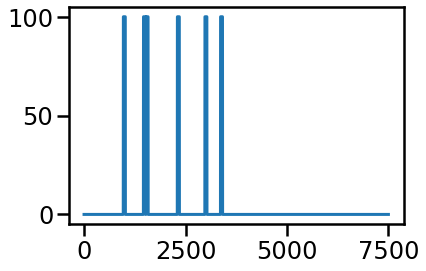

In [5]:
tnum = 39

plt.plot(trial_odor[tnum])
#plt.xlim(3300,3500)


print(np.round(cum_odor[tnum]))
print(high_trials[tnum], correct_trials[tnum], high_choices[tnum])
#pulse_onsets = (np.diff(trial_odor[tnum])>0).astype(np.float)
#print(np.argwhere(pulse_onsets==1).flatten())#print(pulse_onsets[tnum])#
#print(new_onsets[tnum])#, len(pulse_onsets))
#new_onsets = find_odor_onset_new(trial_odor[tnum])

#print(len(new_onsets[tnum]))


(3300.0, 3500.0)

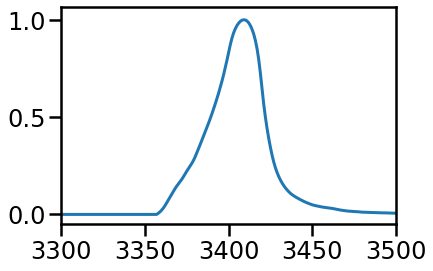

In [6]:
plt.plot(get_odor_profile_actual(trial_odor[tnum]))
plt.xlim(3300,3500)

In [259]:
a = np.zeros(8)
b = np.ones(6)

c = np.append(a,b, axis=0)
print(c)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


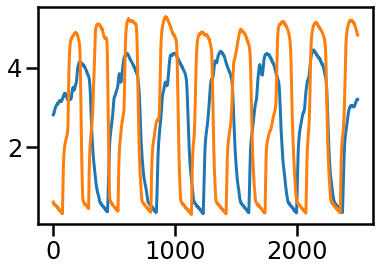

In [267]:
#print(len(session['trial_pre_breath'][0]))
plt.plot(session['trial_pre_breath'][0])
#print(len(session['trial_breath'][0]))
plt.plot(session['trial_breath'][0, -2500:])
plt.plot(get_sniff_histogram())

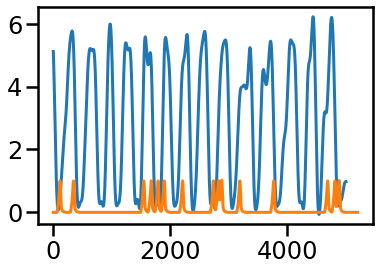

In [109]:
plt.plot(butter_lowpass_filter(session['trial_breath'][141,:5000], 10, 1000))
plt.plot(get_odor_profile_actual(trial_odor[141,:5000]))
plt.savefig('example_pulse_breathing_trace.svg', format='svg', transparent=True, bbox_inches='tight')

In [10]:
# 141 [3198 1243  236 4212 2245 3506  715 3782 1817 4806  521 3847 1602  154
#   441]

141 [ 892 3068 4068 2604 2519 3724   68 4691 1825 4956 2395 3508 1929  705
 3708]
[ 1.88872496e+02  1.20030195e+02  2.38837412e+02  2.17839210e+01
  2.05005867e+02  1.47817212e+01  7.40688499e+01  2.03253706e+02
  1.75016297e+02  1.74130302e+02  1.02003638e+02  1.59889501e+02
  1.00044417e-14  4.23019470e+01 -2.46147330e+01]
[2 1 1 0 1 0 1 1 0 1 2 1 2 0 1]
test_hist = np.asarray([226.06588648, 237.12078767, 195.45673163,  96.6234537,  227.9066512, 157.80518054,  50.25741619,  50.84970368, 169.00180686,  45.89879032, 153.93398714,  95.17350973,  15.81058755, 136.63567179,  95.46609578])
bins = np.linspace(0,250,16) #16

thist,_ = np.histogram(test_hist,bins)
print(thist)

[1 0 1 2 0 3 0 0 1 2 1 1 0 2 1]


In [4]:
sniff_hist[141]

array([0., 2., 1., 0., 0., 3., 0., 1., 0., 1., 2., 3., 1., 0., 0.])

In [6]:
sniff_hist[141]

array([0., 2., 1., 0., 0., 3., 0., 1., 0., 1., 2., 3., 1., 0., 0.])

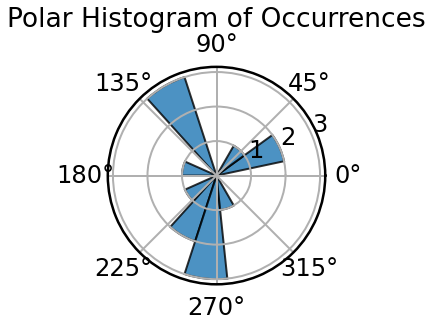

In [111]:
nn_trial = 141
plot_data = sniff_hist[nn_trial]
num_bars = len(plot_data)
# Calculate the angle for each bar
angles = np.linspace(0, 2 * np.pi, num_bars, endpoint=False)

# Set up the polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot each bar with the corresponding height
bars = ax.bar(angles, plot_data, width=2 * np.pi / num_bars, bottom=0, edgecolor='k')

for r, bar in zip(plot_data, bars):
    if r > 0:
        #bar.set_facecolor(plt.cm.viridis(r / max(plot_data)))
        bar.set_alpha(0.8)  # Adjust the transparency level if needed
    else:
        bar.set_facecolor('gray') 

# Optional: Customize colors based on the height of each bar
# for r, bar in zip(plot_data, bars):
#     bar.set_facecolor(plt.cm.viridis(r / max(plot_data) if max(plot_data) > 0 else 0))
#     bar.set_alpha(0.8)  # Transparency level

# Customize the plot as needed
ax.set_title("Polar Histogram of Occurrences")
#sns.despine(offset=20)
#plt.show()

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.hist(sniff_hist[12], bins=15, density=False)  # Adjust the bins as needed
# ax.set_title("Polar Histogram of Occurrences")
# plt.show()
plt.savefig('polar_plot_histogram.svg', format='svg', transparent='true', bbox_inches='tight')
plt.show()

In [28]:
session['trial_odor'][141, 2800:2850]

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.,   0.,   0.,   0.,   0.,   0.,   0., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100.])

(0.0, 5.0)

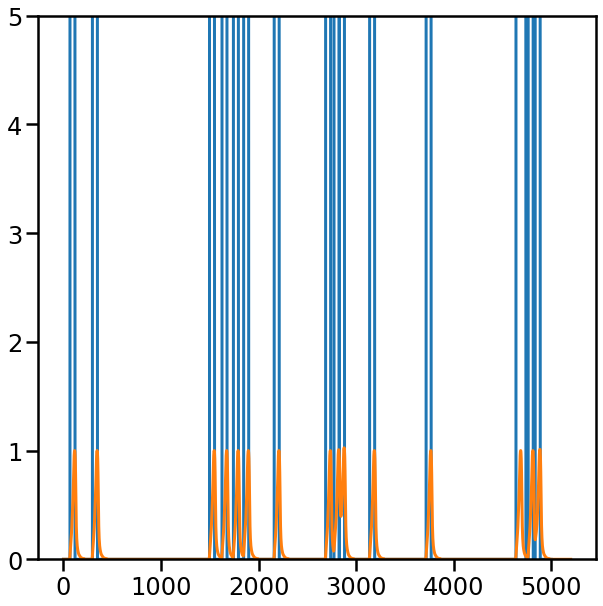

In [4]:
plt.figure(figsize=(10,10))
plt.plot(session['trial_odor'][141,:5000])
plt.plot(get_odor_profile_actual(trial_odor[141,:5000]))
plt.ylim(0,5)
#plt.xlim(2500,3000)


In [9]:
cum_odor[141]

16.0

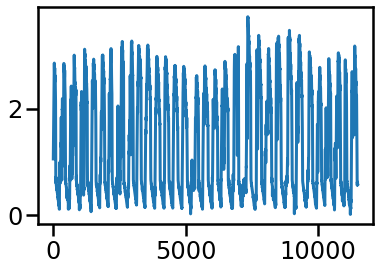

In [116]:
i_trial = 39
sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
plt.plot(sniff_raw)

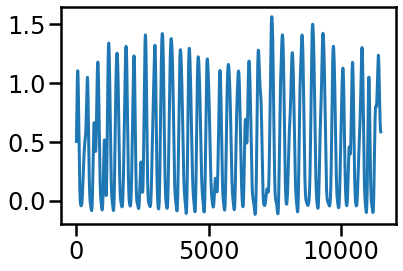

In [117]:
sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
#print(sniff_raw.shape)
sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
sniff = (sniff - sniff.mean()+1)/2
plt.plot(sniff)
#print(sniff.shape)
#sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)

1.0
[0. 0. 0. ... 0. 0. 0.]


(0.0, 1.0)

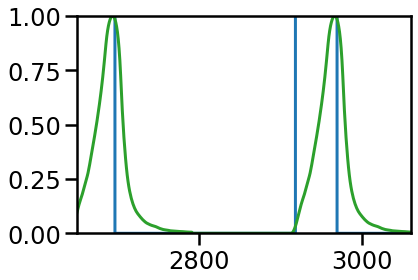

In [169]:
odor_command = session['trial_odor'][i_trial]
odor = get_odor_profile_actual(odor_command)[0:5000]
valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
odor_onset = valve_onset + 20
plt.plot(odor_command)
#plt.plot(odor[0:500])
plt.plot(odor_onset, odor_command[odor_onset], "x")
#plt.xlim(0,1000)
print(odor.max())
odor_for_display = np.zeros(11500,)
odor_for_display[2500:7500] = odor[0:5000]
print(odor_for_display)
plt.plot(odor)
plt.xlim(2650,3060)
plt.ylim(0,1)

In [374]:
odor_onset_for_display = odor_onset + 2500
print(odor_onset_for_display)

[[5205]
 [5645]]


In [152]:
print(len(session['trial_pre_breath'][0]))

5000


(3500.0, 4000.0)

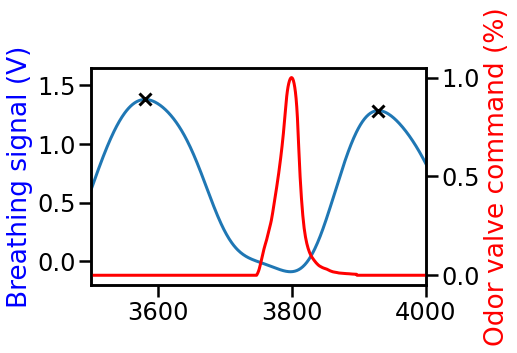

In [170]:
fig, ax1 = plt.subplots()

sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100, width=99)
inh_peaks,_ = scipy.signal.find_peaks(-sniff,distance=100, width=99)
sniff_onset = sniff_onset[sniff_onset>2200]
sniff_onset = sniff_onset[sniff_onset<7800]
inh_peaks = inh_peaks[inh_peaks>2200]
inh_peaks = inh_peaks[inh_peaks<7800]
#print(sniff_onset, inh_peaks)
#print(np.diff(sniff_onset))
#print(len(sniff_onset))
#print(len(inh_peaks))
#print(sniff_onset[:-1])
#print(inh_peaks[1:]-sniff_onset[:-1])
sniff_markers = np.zeros((10000,))
sniff_phase = np.zeros((10000,))

ax1.plot(sniff)
ax1.plot(sniff_onset, sniff[sniff_onset], "x", markeredgewidth=3, color='k')
ax1.set_ylabel('Breathing signal (V)', color='b')
#plt.plot(odor_onset_for_display, odor_for_display[odor_onset_for_display], "x")
ax2 = ax1.twinx()

ax2.plot(odor_for_display, 'r-')
ax2.set_ylabel('Odor valve command (%)', color='r')
plt.xlim(3500,4000)

#plt.xlim(4100,8050)

(4300.0, 5300.0)

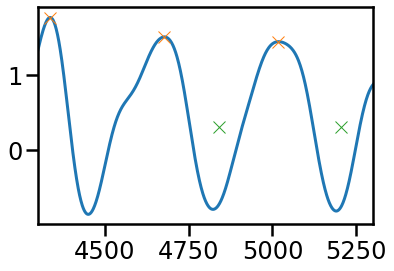

In [359]:
plt.plot(sniff)
plt.plot(sniff_onset, sniff[sniff_onset], "x")
plt.plot(odor_onset_for_display, odor_for_display[odor_onset_for_display], "x")
plt.xlim(4300, 5300)

2834 2571 263
2953 2834 119
3268 2953 315
3542 3268 274
3747 3542 205
3928 3747 181
4249 3928 321
4596 4249 347
4838 4596 242
5099 4838 261
5432 5099 333
5756 5432 324
6058 5756 302
6340 6058 282
6504 6340 164
6863 6504 359
7193 6863 330
7484 7193 291


(0.0, 5000.0)

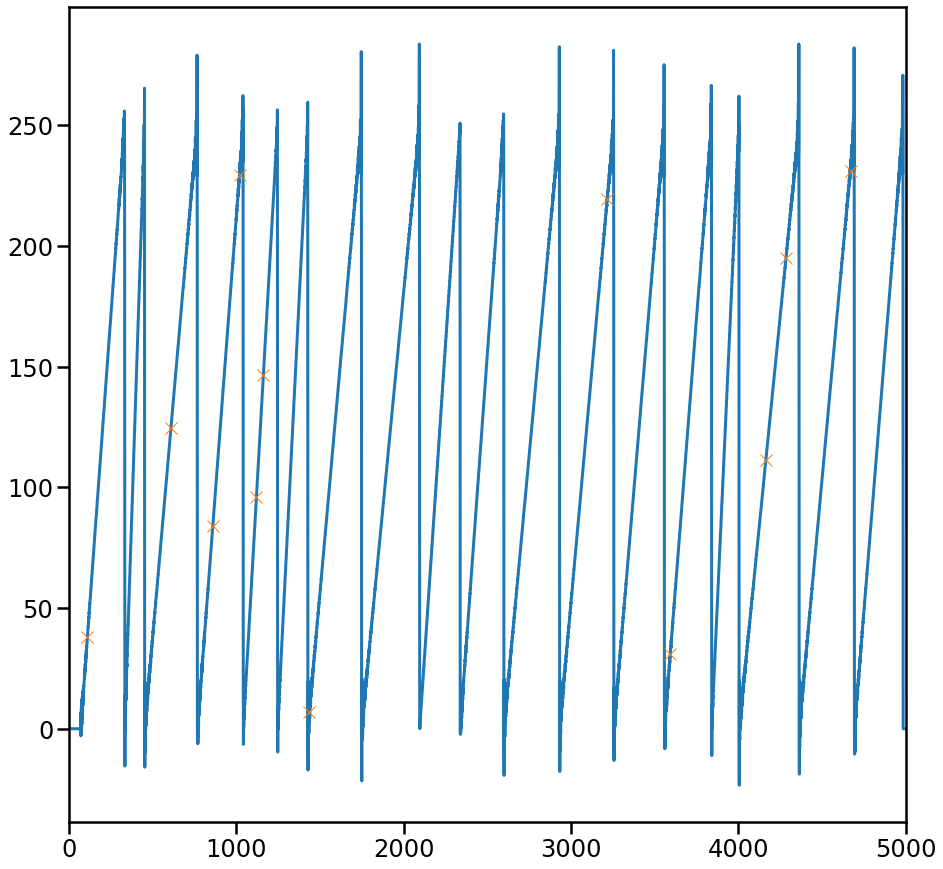

In [178]:
for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            print(sniff_onset[i+1], sniff_onset[i], nsample)
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)

sniff_phase_sampling_epoch = sniff_phase[2500:]
plt.figure(figsize=(15,15))
plt.plot(sniff_phase_sampling_epoch)
#plt.plot(sniff[2500:])
plt.plot(odor_onset, sniff_phase_sampling_epoch[odor_onset], "x")
plt.xlim(0,5000)

In [179]:
odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
print(odor_phase)


[ 37.95473286 124.60378909  83.99258397 229.47458151  96.18625104
 146.49210458   6.94275042 219.53983748  31.13472537 111.50097208
 195.15905925 231.23334018]


In [180]:
hist,bin_edges = np.histogram(odor_phase,15)

In [183]:
print(hist)
print(bin_edges)

[1 1 1 0 0 2 1 1 0 1 0 0 1 0 3]
[  6.94275042  21.8954564   36.84816239  51.80086837  66.75357436
  81.70628034  96.65898632 111.61169231 126.56439829 141.51710428
 156.46981026 171.42251625 186.37522223 201.32792821 216.2806342
 231.23334018]


In [184]:
hist_corr, bin_edges_corr = np.histogram(odor_phase, bins=15, range=(sniff_phase_sampling_epoch.min(), sniff_phase_sampling_epoch.max()))
print(hist_corr, bin_edges_corr)

[0 1 2 0 0 2 1 1 1 0 1 1 2 0 0] [-23.4209038   -2.94085223  17.53919934  38.01925092  58.49930249
  78.97935406  99.45940563 119.9394572  140.41950877 160.89956034
 181.37961191 201.85966348 222.33971506 242.81976663 263.2998182
 283.77986977]


[ 335  454  771 1043 1248 1429 1750 2097 2339 2600 2933 3257 3559 3841
 4005 4364 4694]


(0.0, 5000.0)

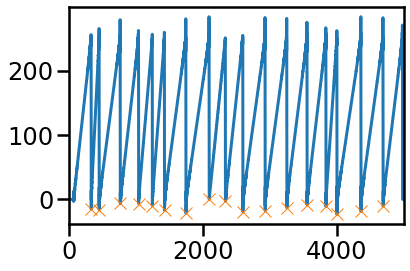

In [206]:
sniff_onset_resampled,_ = scipy.signal.find_peaks(-sniff_phase_sampling_epoch,distance=100, width=1)

print(sniff_onset_resampled)

plt.plot(sniff_phase_sampling_epoch)

plt.plot(sniff_onset_resampled, sniff_phase_sampling_epoch[sniff_onset_resampled], "x")
plt.xlim(0,5000)

In [88]:
def new_phase_hist(i_trial):

    #bins = np.linspace(0,250,16) #16
    num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15)) #15

    for i_trial in range(num_trials):
        
    #i_trial = 9
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        #print(sniff_raw.shape)
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean()+1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100, width=99)
        sniff_onset = sniff_onset[sniff_onset>2200]
        sniff_onset = sniff_onset[sniff_onset<7800]
        odor_command = session['trial_odor'][i_trial]
        odor_onsets_long = np.zeros(10000,)
        # if shuffled:
        #     n_pulses = (np.diff(odor_command)==100).sum()
        #     valve_onset = np.random.randint(0,5000,(n_pulses,))
        # else:
        valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        #print(len(valve_onset))
        odor_onset = valve_onset + 20 + 2500
        odor_onsets_long[odor_onset] = 1
        #plt.plot(odor_onsets_long)
        odor_subarrays = np.split(odor_onsets_long, sniff_onset)
        phase_hists = np.zeros((len(odor_subarrays), 15))
        #print(phase_hists.shape)
        for subarray in range(len(odor_subarrays)):
        #print(odor_subarrays[4].shape, odor_subarrays[4])
            phase_hists[subarray], _ = np.histogram(np.nonzero(odor_subarrays[subarray]), bins=15, range=(0, len(odor_subarrays[subarray])))
            #(np.histogram(np.nonzero(odor_subarrays[subarray]), bins=15, range=(0, len(odor_subarrays[subarray]))))
            print(phase_hists)

        sniff_hist[i_trial] = phase_hists.sum(0)

    return sniff_hist
    #print(phase_hists)
    #print(phase_hists.sum(0))
    #print(phase_hists.sum())


In [283]:
new_phase_hist(25)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])

In [247]:
sniff_subarrays = np.split(sniff, sniff_onset)
odor_subarrays = np.split(odor_onsets_long, sniff_onset)
for i, sub_array in enumerate(sniff_subarrays):
    print(len(sub_array))

print(sniff_onset)

2244
327
382
315
274
386
321
347
242
261
333
324
302
446
359
330
291
2516
[2244 2571 2953 3268 3542 3928 4249 4596 4838 5099 5432 5756 6058 6504
 6863 7193 7484]


In [255]:
#for i, sub_array in enumerate(odor_subarrays):
    #print(sub_array.sum())
print(odor_subarrays[4].shape, odor_subarrays[4])
np.histogram(np.nonzero(odor_subarrays[4]), bins=15, range=(0, len(odor_subarrays[4])))

(274,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([  0.        ,  18.26666667,  36.53333333,  54.8       ,
         73.06666667,  91.33333333, 109.6       , 127.86666667,
        146.13333333, 164.4       , 182.66666667, 200.93333333,
        219.2       , 237.46666667, 255.73333333, 274.        ]))

In [ ]:
for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

In [139]:
def get_sniff_histogram(session,shuffled=False):
    bins = np.linspace(0,250,16) #16
    num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15)) #15
    
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100, width=99)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_phase = np.zeros((10000,))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

def get_sniff_histogram_ranged(session,shuffled=False):
    bins = np.linspace(0,250,16) #16
    num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15)) #15
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        #print(sniff_raw.shape)
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        #print(sniff.shape)
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100, width=99)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_phase = np.zeros((10000,))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase, bins, range=(sniff_phase_sampling_epoch.min(), sniff_phase_sampling_epoch.max()))
        sniff_hist[i_trial,:] = hist
    return sniff_hist

In [140]:
test1 = get_sniff_histogram(session)
test2 = get_sniff_histogram_ranged(session)
test3 = new_phase_hist(session)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [141]:
test_trial = 5

print(test1[test_trial])
print(test2[test_trial])
print(test3[test_trial])

[0. 1. 0. 0. 3. 0. 2. 0. 1. 0. 1. 0. 1. 1. 0.]
[1. 2. 0. 4. 0. 1. 1. 2. 0. 1. 0. 0. 3. 1. 0.]
[2. 1. 0. 4. 0. 1. 1. 2. 0. 1. 0. 0. 3. 1. 0.]


NameError: name 'test_trial' is not defined

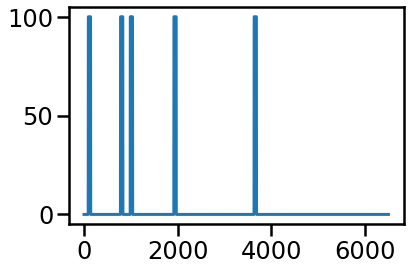

In [48]:
plt.plot(session['trial_odor'][0])
plt.plot(np.append(session['trial_pre_breath'][test_trial],session['trial_breath'][test_trial]))

In [75]:
def find_odor_onset_new(trial_odor):
    odor_onsets_list = list()

    for i_trial in range(len(trial_odor)):
        onset_marks = (np.diff(trial_odor[i_trial])>0).astype(np.float)
        pulse_onsets = np.argwhere(onset_marks==1).flatten()
        #print(pulse_onsets)
        odor_onsets_list.append(pulse_onsets.tolist())
    return odor_onsets_list

def get_blanks_duration(session):
    #coef_var = np.zeros(len(odor_onsets_array))
    num_trials = session['num_trials']
    cv_blanks = np.zeros(num_trials)
    blanks_durations =  list()
    for i_trial in range(num_trials):
        no_odor = (session['trial_odor'][i_trial]==0).astype(int)
        no_odor_changes = np.diff(no_odor)
        starts = np.where(no_odor_changes == 1)[0] + 1  # Start indices of 1s
        ends = np.where(no_odor_changes == -1)[0] + 1   # End indices of 1s

        # Ensure that the signal starts or ends with 1
        if no_odor[0] == 1:
            starts = np.insert(starts, 0, 0)
        if no_odor[-1] == 1:
            ends = np.append(ends, len(no_odor))

        # Compute durations
        durations = ends - starts
        blanks_durations.append(durations)
        cv_blanks[i_trial] = durations.std()/durations.mean() 
    return blanks_durations, cv_blanks

# coef_var = np.zeros(len(odor_onsets_array))
#     blanks_duration =  []
#     for i in range(len(odor_onsets_array)):
#         trial_odor_onsets = odor_onsets_array[i]
#         new_array = np.insert(trial_odor_onsets, 0, 0)
#         new_array = np.insert(new_array, len(new_array), 5000)
#         blanks_ = np.diff(new_array)
#         blanks_duration.append(blanks_)
#         coef_var[i] = blanks_.std()/blanks_.mean()

In [81]:
yyy, zzz = get_blanks_duration(session)
print(yyy[0])
print(zzz.min())

[ 352  511  312  830   50   94  173  648  431    1  122  365   41   93
 1650]
0.2099086775798129


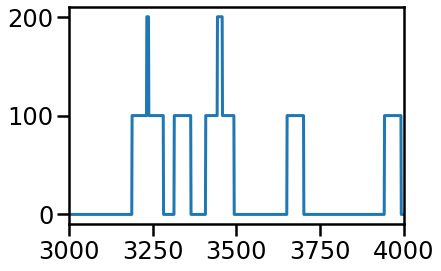

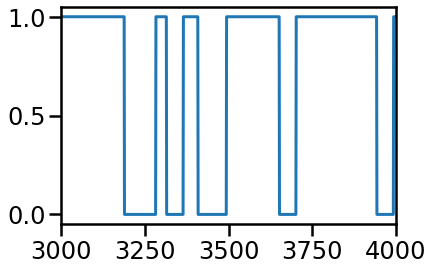

[ 356 1207  176  376  874   32   44  158  241   38 2419]


In [59]:
plt.plot(trial_odor[4])
plt.xlim(3000,4000)
plt.show()
ttt = (trial_odor[4]==0).astype(int)
plt.plot(ttt)
plt.xlim(3000,4000)

plt.show()
# Find transitions where signal changes from 0 to 1 and 1 to 0
diffs = np.diff(ttt)
starts = np.where(diffs == 1)[0] + 1  # Start indices of 1s
ends = np.where(diffs == -1)[0] + 1   # End indices of 1s

# Ensure that the signal starts or ends with 1
if ttt[0] == 1:
    starts = np.insert(starts, 0, 0)
if ttt[-1] == 1:
    ends = np.append(ends, len(ttt))

# Compute durations
durations = ends - starts

print(durations)

In [385]:
sns.histplot(x=range(test1.shape[1]), y = test1[,:])

SyntaxError: invalid syntax (427883884.py, line 1)

In [130]:
def get_sniff_durations(session):
    num_trials = session['num_trials']
    sniff_durations = np.zeros((num_trials,50))
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(-sniff,distance=100, width=99)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_duration = np.diff(sniff_onset)
        sniff_durations[i_trial,:len(sniff_duration)] = sniff_duration
    return sniff_durations

In [131]:
test_z = get_sniff_durations(session)
test_z_nan = np.where(test_z==0, np.nan, test_z)

In [132]:
np.nanvar(test_z_nan)

6606.138998214639

In [388]:
test3.sum(0)

array([102., 137., 171., 139., 126., 143., 142., 136., 142., 123., 135.,
       156., 192., 182.,  69.])

In [11]:
matlab_filepath = os.getcwd() + '/HW1_50ms_odor.mat'
file = scipy.io.loadmat(matlab_filepath)


In [12]:
file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue Aug 27 09:43:35 2024',
 '__version__': '1.0',
 '__globals__': [],
 'breath': array([[0.27814027, 0.26482999, 0.26353143, ..., 0.        , 0.        ,
         0.        ]]),
 'odor': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'valve': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [34]:
print(len(file['valve'][0]))
print(len(file['odor'][0]))
print(len(file['breath'][0]))

2119200
2119200
2119200


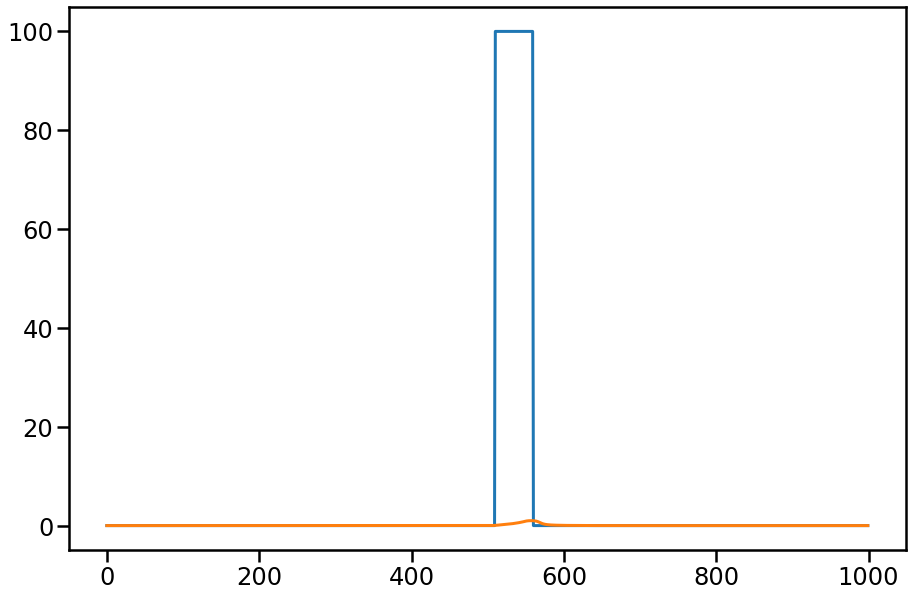

In [40]:
plt.figure(figsize=(15,10))
plt.plot(file['valve'][0][0:1000])

plt.plot(file['odor'][0][0:1000])
#plt.xticks(np.arange(0,60000,5000))

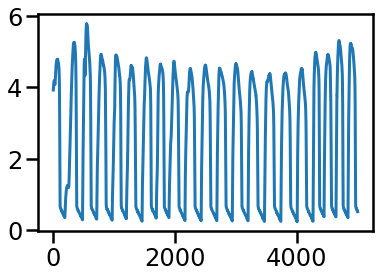

In [46]:
plt.plot(file['breath'][0][5000:10000])

In [47]:
sniff = butter_lowpass_filter(file['breath'][0],12,1000,3)
sniff = (sniff - sniff.mean()+1)/2

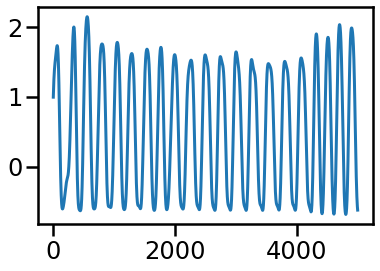

In [48]:
plt.plot(sniff[5000:10000])

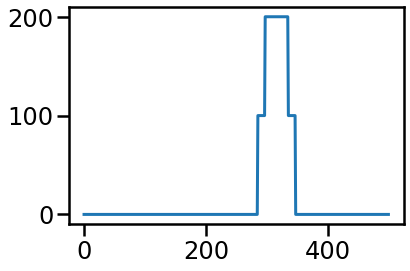

In [78]:
plt.plot(file['valve'][0][31000:31500])

In [69]:
valve = file['valve'][0].astype(np.int16)

In [74]:
diff_valve = np.diff(valve)
print(diff_valve[550:570])
valve_onsets = np.argwhere(diff_valve==100)
print(len(valve_onsets))

[   0    0    0    0    0    0    0    0    0 -100    0    0    0    0
    0    0    0    0    0    0]
1245


In [80]:
valve_onset = np.argwhere(np.diff(file['valve'][0]==100))
print(valve_onset[36:47])

[[31334]
 [31346]
 [33014]
 [33064]
 [33464]
 [33514]
 [34001]
 [34051]
 [37037]
 [37087]
 [41283]]


In [ ]:
def get_sniff_histogram_adapted(breathing,odor,valve):
    
    bins = np.linspace(0,250,16) #16
    #num_trials = session['num_trials']
    sniff_hist = np.zeros((num_trials,15)) #15
        
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,8,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_phase = np.zeros((10000,))

        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            sniff_phase[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(np.arange(0,250),nsample)
        sniff_phase_sampling_epoch = sniff_phase[2500:]
        odor_command = session['trial_odor'][i_trial]
        if shuffled:
            n_pulses = (np.diff(odor_command)==100).sum()
            valve_onset = np.random.randint(0,5000,(n_pulses,))
        else:
            valve_onset = np.argwhere(np.diff(odor_command)==100)[0:5000]
        odor_onset = valve_onset + 20
        odor_phase = sniff_phase_sampling_epoch[odor_onset].squeeze()
        hist,_ = np.histogram(odor_phase,bins)
        sniff_hist[i_trial,:] = hist
    return sniff_hist

In [82]:
matlab_filepath = os.getcwd() + '/Kernel_workspace.mat'
file = scipy.io.loadmat(matlab_filepath)

In [84]:
file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'HW1_mid', 'HW1_onset', 'HW1_peak', 'HW4_mid', 'HW4_onset', 'HW4_peak', 'Sphinx_mid', 'Sphinx_onset', 'Sphinx_peak'])

In [85]:
hw1_mid = file['HW1_mid']
hw1_onset = file['HW1_onset']
hw1_peak = file['HW1_peak']
hw4_onset = file['HW4_onset']
hw4_mid = file['HW4_mid']
hw4_peak = file['HW4_peak']
sphinx_mid = file['Sphinx_mid']
sphinx_onset = file['Sphinx_onset']
sphinx_peak = file['Sphinx_peak']

In [86]:
hw1_mid.shape

(18, 15)

In [ ]:
plt.plot(np.arange(16), )